<a href="https://colab.research.google.com/github/Surendra58/AI/blob/master/Neural_Turing_Machine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Turing Machine

## Setup

In [ ]:
# Clone the code repository
!git clone https://github.com/theneuralbeing/ntm

Cloning into 'ntm'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 15 (delta 0), reused 15 (delta 0), pack-reused 0
Unpacking objects: 100% (15/15), done.


In [ ]:
cd ntm

/content/ntm


## Train

In [ ]:
%%time
# Run training script
!python train.py

  0% 0/10000 [00:00<?, ?it/s]Step 0 == Loss 0.695 == Error 31.0 bits per sequence
  2% 200/10000 [00:27<26:29,  6.16it/s]Step 200 == Loss 0.694 == Error 42.13 bits per sequence
  4% 400/10000 [00:51<28:36,  5.59it/s]Step 400 == Loss 0.693 == Error 38.79 bits per sequence
  6% 600/10000 [01:17<25:33,  6.13it/s]Step 600 == Loss 0.690 == Error 38.395 bits per sequence
  8% 800/10000 [01:42<24:48,  6.18it/s]Step 800 == Loss 0.678 == Error 34.845 bits per sequence
 10% 1000/10000 [02:08<17:23,  8.63it/s]Step 1000 == Loss 0.661 == Error 35.67 bits per sequence
 12% 1200/10000 [02:35<21:15,  6.90it/s]Step 1200 == Loss 0.628 == Error 32.85 bits per sequence
 14% 1400/10000 [03:02<24:01,  5.96it/s]Step 1400 == Loss 0.594 == Error 28.83 bits per sequence
 16% 1600/10000 [03:28<22:26,  6.24it/s]Step 1600 == Loss 0.558 == Error 24.47 bits per sequence
 18% 1800/10000 [03:53<18:47,  7.27it/s]Step 1800 == Loss 0.484 == Error 18.46 bits per sequence
 20% 2000/10000 [04:19<15:58,  8.35it/s]Step 2000 =

## Predict

In [ ]:
import json
from tqdm import tqdm
import numpy as np
import os
import argparse

import torch
from torch import nn, optim
from torchvision import transforms as T

from ntm import NTM
from task_generator import CopyDataset, AssociativeDataset

### Task Data

In [ ]:
# ==== Load the Task Configuration files ====
# Copy Task ===
task_params = json.load(open('configs/copy.json'))
task_params['min_seq_len'] = 100
task_params['max_seq_len'] = 120

# Associative Recall Task ===
# task_params['min_item'] = 6
# task_params['max_item'] = 9

In [ ]:
# ==== Create Dataset ====
dataset = CopyDataset(task_params)

### Model

In [ ]:
# ==== Create NTM ====
ntm = NTM(input_dim=task_params['seq_width'] + 2,
          output_dim=task_params['seq_width'],
          ctrl_dim=task_params['controller_size'],
          memory_units=task_params['memory_units'],
          memory_unit_size=task_params['memory_unit_size'],
          num_heads=task_params['num_heads'])

In [ ]:
# Load trained model weights
ntm.load_state_dict(torch.load('model_copy.pt'))

<All keys matched successfully>

### Predict

In [ ]:
# Reset
ntm.reset()

# Sample data
data = dataset[np.random.randint(65536)]
inputs, target = data['input'], data['target']

# Tensor to store outputs
out = torch.zeros(target.size())

# Process the inputs through NTM for memorization
for i in range(inputs.size()[0]):
    # Forward passing all sequences for read
    ntm(inputs[i].unsqueeze(0))

# Get the outputs from memory without real inputs
zero_inputs = torch.zeros(inputs.size()[1]).unsqueeze(0) # dummy inputs
for i in range(target.size()[0]):
    out[i] = ntm(zero_inputs)

# Calculate binary outputs
binary_output = out.clone()
binary_output = binary_output.detach().apply_(lambda x: 0 if x < 0.5 else 1)

# Sequence prediction error is calculted in bits per sequence
error = torch.sum(torch.abs(binary_output - target))

print(f'Output Shape: {binary_output.size()}')
print(f'Error: {error} bits per sequence')

Output Shape: torch.Size([118, 8])
Error: 0.0 bits per sequence


### Visualize

In [ ]:
# Transforms Compose object
visualize = T.Compose([T.ToPILImage(), T.Resize(128, interpolation=0)])

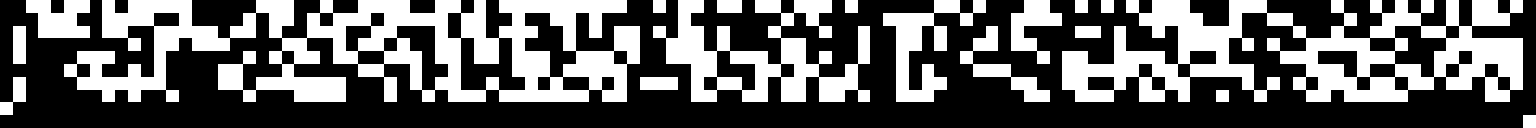

In [ ]:
# Visualize Input (with delimiters)
visualize(inputs.permute(1, 0))

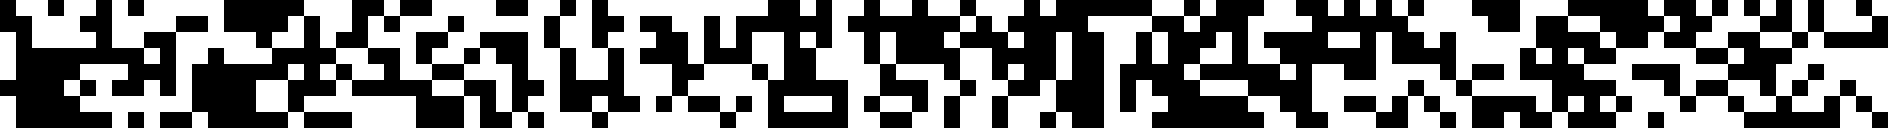

In [ ]:
# Visualize Predicted Output
visualize(binary_output.permute(1, 0))